In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/drive/MyDrive/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/yolov5


In [1]:
pwd

'/content'

In [ ]:
  !pip install -U -r requirements.txt

In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

In [ ]:
# !rm -rf train/images
# !rm -rf train/labels

In [ ]:
!mkdir train/
!mkdir train/images
!mkdir train/labels
!mkdir valid/
!mkdir valid/images
!mkdir valid/labels
!mkdir test/
!mkdir test/images
!mkdir test/labels

In [ ]:
import os
import shutil
import csv
import sys
import cv2
import glob as glob
import matplotlib.pyplot as plt



kitti_dir = '/content/drive/My Drive/small_kitti_dataset/'

imageFolder = kitti_dir + "data_object_image_2/training/image_2/"
labelFolder = kitti_dir + "data_object_label_2/training/label_2/"
kitti2yolo_labels = kitti_dir+'kitti2yolo_labels/'

training_amount = 3500

os.makedirs(kitti2yolo_labels, exist_ok=True)

classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
# classes = ['vehicle_0','vehicle_45','vehicle_90','vehicle_135','vehicle_180','vehicle_225','vehicle_270','vehicle_315',]



In [ ]:
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 #- 1
    y = (box[2] + box[3])/2.0 #- 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x, y, w, h)

In [ ]:
!ls


shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [ ]:
# import zipfile

# zip_file_path = '/content/drive/MyDrive/data_object_label_2.zip'

# # Define the extraction destination
# extraction_path = kitti_dir+labelFolder
# # Unzip the dataset
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)

In [ ]:
  # with open("/content/drive/MyDrive/small_kitti_dataset/data_object_label_2/training/label_2/000000.txt") as csv_file:
  #     reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
  #     yolo_labels = []
  #     for row in reader:
  #       print(row)

In [ ]:
def convert_annotation(imgFile, label):
    img = cv2.imread(imageFolder + imgFile)
    h = int(img.shape[0])
    w = int(img.shape[1])

    in_file = labelFolder + label
    out_file = open(kitti2yolo_labels + label,'w')

    with open(in_file) as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
        yolo_labels = []
        for row in reader:
            bbox = (
                  float(row["bbox2_left"]),
                  float(row["bbox2_right"]),
                  float(row["bbox2_top"]),
                  float(row["bbox2_bottom"])
                  )
            yolo_bbox = convert((w, h), bbox)
            cls_id=classes.index(row["type"])
            yolo_labels.append(str(cls_id) + " " + " ".join([str(x) for x in yolo_bbox]) + "\n")

        for l in yolo_labels:

          out_file.write(l)


    out_file.close()

Converting the kitti labels to yolo fitter labels

In [ ]:
images = sorted(os.listdir(imageFolder))
images = [f for f in images if f.endswith('.png')]
labels = sorted(os.listdir(labelFolder))
labels = [f for f in labels if f.endswith('.txt')]

# print(labelsOutput)
print(len(images))
print(len(labels))


for i in range(training_amount):
    label = images[i].replace('.png', '.txt')
    convert_annotation(images[i],label)

In [ ]:


allImages = []
for index, filename in enumerate(os.listdir(imageFolder)):
    if filename.endswith(".png") and len(allImages)<=training_amount:
      allImages.append(filename)

print(len(allImages))

trainImages = []
validImages = []
trainLabels = []
validLabels = []
testImages = []
testLabels = []

total = len(allImages)-100
testCount = int(0.2 * total )
trainCount = total - testCount-1
valCount = int(0.2 * trainCount)
trainCount = trainCount - valCount-1

print(trainCount, valCount, testCount)


# create training Dataset
j = 0
k = 0
for i in range(0,total):

  if i < trainCount: # create training images
    trainImages.append(allImages[i])
  elif i >= trainCount and i<(valCount + trainCount):
    validImages.append(allImages[i])
    # j += 1
  else:
    testImages.append(allImages[i])
    # k += 1

print(len(trainImages), len(validImages), len(testImages))

# moving training data
for fileT in trainImages:
  print(fileT)
  shutil.copy(imageFolder+fileT , "train/images/"+fileT)

  fileT = fileT.replace(".png",".txt")
  shutil.copy(kitti2yolo_labels+fileT , "train/labels/"+fileT)




#moving validation data
for fileT in validImages:
  shutil.copy(imageFolder+fileT , "valid/images/"+fileT)

  fileT = fileT.replace(".png",".txt")
  shutil.copy(kitti2yolo_labels+fileT , "valid/labels/"+fileT)

  #moving test data
for fileT in testImages:
  shutil.copy(imageFolder+fileT , "test/images/"+fileT)

  fileT = fileT.replace(".png",".txt")
  shutil.copy(kitti2yolo_labels+fileT , "test/labels/"+fileT)






In [ ]:

import os
images = sorted(os.listdir('train/images/'))
train_images = [f for f in images if f.endswith('.png')]
labels = sorted(os.listdir("train/labels/"))
train_labels = [f for f in labels if f.endswith('.txt')]
images = sorted(os.listdir('valid/images/'))
valid_images = [f for f in images if f.endswith('.png')]
labels = sorted(os.listdir("valid/labels/"))
valid_labels = [f for f in labels if f.endswith('.txt')]
images = sorted(os.listdir('test/images/'))
test_images = [f for f in images if f.endswith('.png')]
labels = sorted(os.listdir("test/labels/"))
test_labels = [f for f in labels if f.endswith('.txt')]

# print(labelsOutput)
print(len(train_images), len(train_labels))
print(len(valid_images), len(valid_labels))
print(len(test_images), len(test_labels))

2183 2183
551 551
690 690


In [ ]:
num_classes = 9

data = f"""
train: ../train/images
val: ../valid/images

nc: {9}
names: ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

train: &train
  augment: True

"""

# Write the content to the file
with open('data.yaml', 'w') as file:
    file.write(data)

In [ ]:
%cat data.yaml

In [ ]:
#Function to Monitor TensorBoard logs.

def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
#monitor_tensorboard()
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=/tmp  --port=8008

In [ ]:
%cat models/yolov5s.yaml

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 9  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Sat Dec  2 18:09:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------

In [ ]:
%cat models/custom_yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 9  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:

data = f"""
lrf: 0.007
lr0: 0.007
momentum: 0.937
weight_decay: 0.00083
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.381
cls_pw: 0.531
obj: 0.518
obj_pw: 0.956
iou_t: 0.2
anchor_t: 2.0
fl_gamma: 0.0
hsv_h: 0.0205
hsv_s: 0.9
hsv_v: 0.604
degrees: 0.3
translate: 0.1
scale: 0.7
shear: 0.1
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0

"""

# Write the content to the file
with open('hyp_evolved.yaml', 'w') as file:
    file.write(data)

In [ ]:
%%time
!python train.py --img 640 --batch 16 --epochs 30 --data 'data.yaml' --cfg ./models/custom_yolov5s.yaml  --name yolov5s_results --weights ''

In [ ]:
%%time
!python train.py --img 640 --batch 16 --epochs 30 --data 'data.yaml' --cfg ./models/custom_yolov5s.yaml  --name yolov5s_results

In [ ]:
# !rm -rf runs/train/yolov5s_results4
!python train.py --resume

  1. Box Loss - assosciatedwith the localization accuracy of the predicted bounding boxes
  2. Objectness Loss - measures the confidence of the model in predicting that there is an object present in the bounding box
  3. Class Loss - related to the accuracy of predicting the class labels of the objects within the bounding boxes.

  The final loss is a weighted sum of these three components.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize(csv_path, title='', n=0):
  df = pd.read_csv(csv_path)

  df.columns = df.columns.str.strip()

  train_loss = df['train/box_loss']+df['train/obj_loss']+df['train/cls_loss']
  val_loss = df['val/box_loss']+df['val/obj_loss']+df['val/cls_loss']

  if n==0: n=len(train_loss)
  epochs = range(1, n+1)

  plt.figure(figsize=(8, 6))
  plt.plot(epochs, train_loss[:n], label='Training Loss',  )
  plt.plot(epochs, val_loss[:n], label='Validation Loss',  )
  # plt.plot(epochs, df['train/box_loss'][:n], label='train/box Loss', )
  # plt.plot(epochs, df['val/box_loss'][:n], label='val/box Loss', )

  # plt.plot(epochs, df['metrics/mAP_0.5'][:n], label='mAP_0.5', )
  plt.title('Training and Validation Loss\n'+title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()


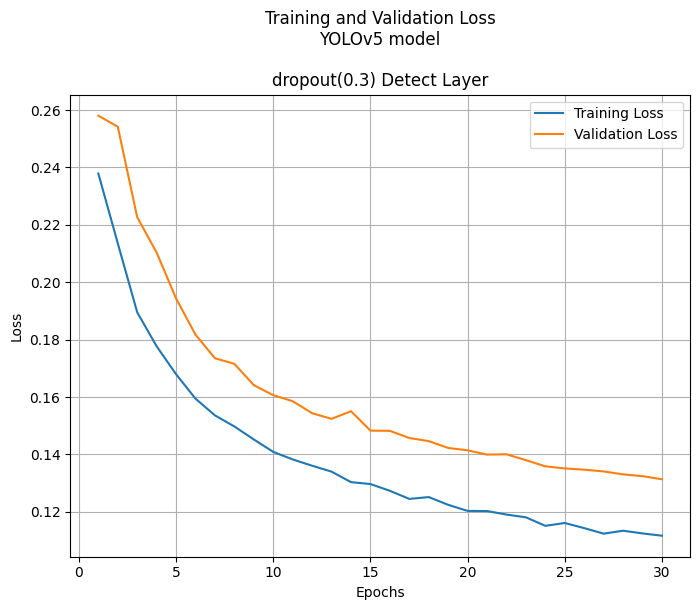

In [91]:




visualize('runs/train/yolov5s_results23/results.csv', '''YOLOv5 model\n
dropout(0.3) Detect Layer''', )


In [62]:
!python val.py --data data.yaml --weights runs/train/yolov5m_results6/weights/best.pt

val: data=data.yaml, weights=['runs/train/yolov5m_results6/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-231-gc2f131a Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
custom_YOLOv5m summary: 213 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
val: Scanning /content/drive/MyDrive/yolov5/valid/labels.cache... 551 images, 0 backgrounds, 0 corrupt: 100% 551/551 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 18/18 [00:12<00:00,  1.43it/s]
                   all        551       3881      0.818      0.698      0.754       0.46
                   Car        551       2095      0.901      0.874      0.928      0.68

In [ ]:
import os
import yaml
import pandas as pd

def process_model(model_name):
    model_folder = f'/content/drive/MyDrive/yolov5/runs/train/{model_name}'
    results_path = os.path.join(model_folder, 'results.csv')
    hyp_path = os.path.join(model_folder, 'hyp.yaml')

    # Read results.csv
    results_df = pd.read_csv(results_path)
    results_df.columns = results_df.columns.str.strip()

    # Read hyp.yaml
    with open(hyp_path, 'r') as hyp_file:
        hyp_data = yaml.safe_load(hyp_file)

    # Get the last epoch metrics, average by 30 epochs

    print(len(results_df))
    if(len(results_df)>29):
       results_df = results_df[:30]

    last_epoch_metrics = results_df.iloc[-1]

    # Calculate training and validation loss
    training_loss = last_epoch_metrics['train/box_loss'] + last_epoch_metrics['train/obj_loss'] + last_epoch_metrics['train/cls_loss']
    validation_loss = last_epoch_metrics['val/box_loss'] + last_epoch_metrics['val/obj_loss'] + last_epoch_metrics['val/cls_loss']

    # Extract relevant metrics
    precision = last_epoch_metrics['metrics/precision']
    recall = last_epoch_metrics['metrics/recall']
    mAP_0_5 = last_epoch_metrics['metrics/mAP_0.5']


    # Filter hyp.yaml parameters with values greater than 0
    filtered_hyp = {key: value for key, value in hyp_data.items() if isinstance(value, (int, float)) and value > 0}

    # Create a new row with the extracted information
    new_row = {
        'model': model_name,
        'train/loss': training_loss,
        'val/loss': validation_loss,
        'precision': precision,
        'recall': recall,
        'mAP_0.5': mAP_0_5,

        **filtered_hyp
    }

    return new_row

# Specify the folder containing models
model_folders = ['yolov5s_results8', 'yolov5s_results9', 'yolov5s_results7', 'yolov5s_results13', 'yolov5s_results14', 'yolov5s_results15', 'yolov5s_results16', 'yolov5s_results18', 'yolov5s_results19', 'yolov5s_results20']

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate through each model folder
for model_folder in model_folders:
    new_row = process_model(model_folder)
    result_df = result_df.append(new_row, ignore_index=True)

# Save the result to a new CSV file
result_df.to_csv('output2.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_output(csv_path, title='', n=0):
  df = pd.read_csv(csv_path)

  df.columns = df.columns.str.strip()

  train_loss = df['train/loss']
  val_loss = df['val/loss']
  overfit_index =  df['val/loss'] - df['train/loss']
  n = len(df)


  plt.figure(figsize=(5, 4))
  plt.scatter(overfit_index, df['weight_decay']*10, label='weight vs overfit', color='orange', alpha=0.7)
  plt.scatter(overfit_index, df['lr0'], label='lr0 vs overfit', color='blue', alpha=0.7)

  plt.title('Overfitting versus Hyperparameters after Dropout' + title)
  plt.xlabel('Overfit index - train/loss - val/loss')
  plt.ylabel('Hyper Parameters')
  plt.legend()
  plt.grid(True)
  plt.show()




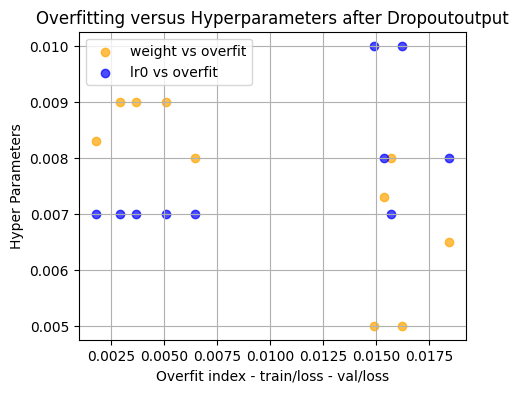

In [ ]:
visualize_output('output2.csv', 'output')

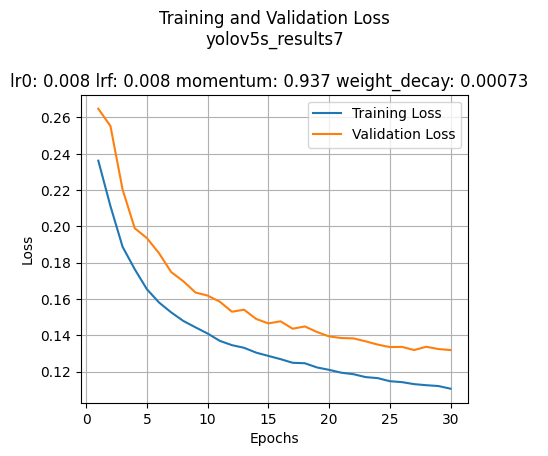

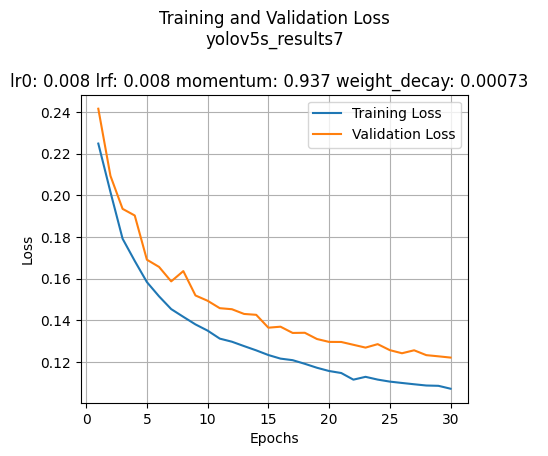

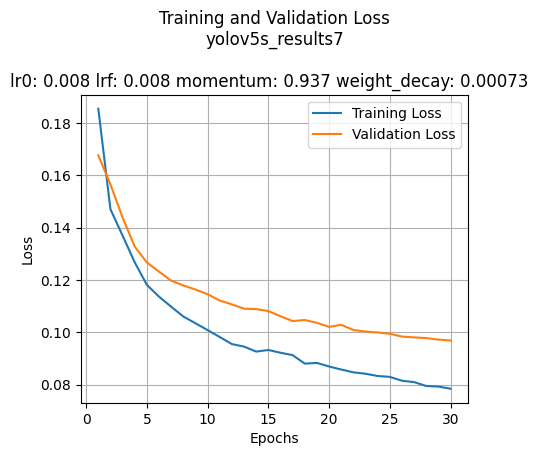

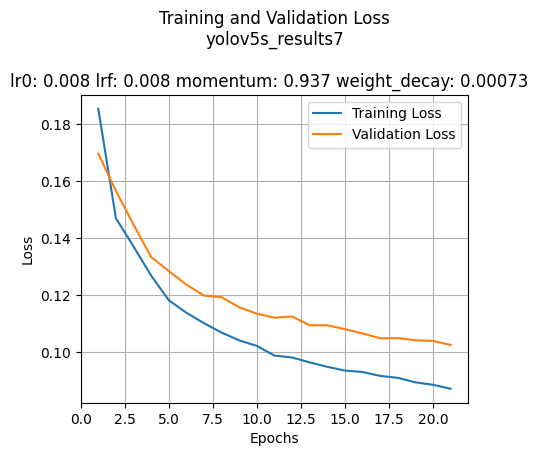

Tflite Quantization

In [ ]:
!python export.py --weights runs/train/yolov5m_results3/weights/best.pt --include tflite --img-size 640

In [ ]:
pwd

In [26]:

def export_model(RES_DIR):
  !python export.py --weights runs/train/{RES_DIR}/weights/best.pt --include tflite --img-size 640

In [24]:
import tensorflow as tf
import os

def quantize_model(RES_DIR):
    tflite_path = f'runs/train/{RES_DIR}/weights/best-fp16.tflite'
    if os.path.exists(tflite_path):
      with open(tflite_path, 'rb') as file:
            tflite_model = file.read()
      return tflite_model

    export_model(RES_DIR)
    saved_model = f'runs/train/{RES_DIR}/weights/best_saved_model'
    converter  = tf.lite.TFLiteConverter.from_saved_model(saved_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()
    return tflite_quant_model

In [33]:

# RES_DIR ="yolov5s_results20"

# len(quantize_model(RES_DIR))

RES_DIR ="yolov5m_results6"

len(quantize_model(RES_DIR))


41924600

In [ ]:
import os
images = sorted(os.listdir('train/images/'))
train_images = [f for f in images if f.endswith('.png')]

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.

    yield [input_value]



converter =  tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/yolov5/runs/train/yolov5s_results20/weights/best_saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.allow_custom_ops = True
converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

with open('model_with_repres_ds_int_custom_haro_ds.tflite', 'wb') as w:
    w.write(tflite_model)


Compiling TFLite model fro EdgeTPU

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

In [ ]:
!pip install -q tflite-support

In [42]:
!edgetpu_compiler runs/train/yolov5m_results6/weights/best-fp16.tflite --show_operations

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 256 ms.

Input model: runs/train/yolov5m_results6/weights/best-fp16.tflite
Input size: 39.98MiB
Output model: best-fp16_edgetpu.tflite
Output size: 39.97MiB
On-chip memory used for caching model parameters: 0.00B
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 503
Operation log: best-fp16_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 503

Operator                       Count      Sta

In [ ]:
from google.colab import files
files.download('best-fp16_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!python detect.py --weights runs/train/yolov5s_results23/weights/best.pt --img 640 --conf 0.4 --source test/images

In [ ]:
import glob
from IPython.display import Image, display

for k, imageName in enumerate(glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp/*.png')):
    display(Image(filename=imageName))
    print("\n")
    if k>10: break

In [ ]:


def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else:
        print('File already present, skipping download...')

In [ ]:
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/yolov5_inference_data.zip',
              'inference_data.zip')
if not os.path.exists('inference_images'):
    !unzip -q "inference_data.zip"
else:
    print('Dataset already present')

In [ ]:
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
def visualize(INFER_DIR):

    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
def inference(RES_DIR, data_path):

    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)

    print(data_path)
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [ ]:
RES_DIR = 'yolov5s_results20'


In [ ]:
show_valid_results(RES_DIR)

In [ ]:
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
!python detect.py --weights runs/train/yolov5l_results2/weights/best.pt --img 640 --conf 0.4 --source test/images

Traceback (most recent call last):
  File "/content/drive/MyDrive/yolov5/detect.py", line 46, in <module>
    from ultralytics.utils.plotting import Annotator, colors, save_one_box
ModuleNotFoundError: No module named 'ultralytics'


In [ ]:
inference(RES_DIR, 'inference_videos')

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('runs/detect/inference_2/video_1.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)